<a href="https://colab.research.google.com/github/Sopralapanca/Pattern-Recognition/blob/main/ASSIGNMENT_1_GIACOMO_CARFI_AUTOENCODER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train a denoising or a contractive autoencoder on the MNIST dataset: try out different architectures for the autoencoder, including a single layer autoencoder, a deep autoencoder with only layerwise pretraining and a deep autoencoder with fine tuning. It is up to you to decide how many neurons in each layer and how many layers you want in the deep autoencoder. Show an accuracy comparison between the different configurations.

Given the encoding z1 of image x1 (obtained in the hidden layer of the autoencoder) and z2 of image x2, a latent space interpolation is an encoding that is obtained with the linear interpolation z* = a*z1 + (1 - a)*z2, with a in [0, 1]. Perform a latent space interpolation (with some choices of a) using:
- z1 and z2 from the same class
- z1 and z2 from different classes

Once you have the interpolated encoding z* visualize its image reconstructions (obtained through the decoder) and discuss the results.

# Loading the dataset

Using PyTorch to download the dataset and to create the models

In [1]:
%%capture
!pip install torchview

In [2]:
%%capture
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchview import draw_graph

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

In [3]:
def split_data_and_label(dataset):
  X = dataset.data.float()
  y = dataset.targets
  return X,y

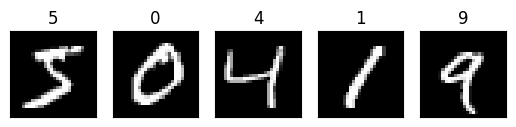

In [4]:
# visualize the data
import matplotlib.pyplot as plt
import numpy as np

def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img, cmap='gray', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        plt.title(y.item())

X_train, y_train = split_data_and_label(train_data)
X_test, y_test = split_data_and_label(test_data)

plot_example(X_train, y_train)

# Preparing the dataset

In [5]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()

# resize the dataset - flatten
X_train = X_train.view(-1, 784)
X_test = X_test.view(-1, 784)

# scaling the dataset
X_train = torch.Tensor(minmaxscaler.fit_transform(X_train))
X_test = torch.Tensor(minmaxscaler.transform(X_test))
print("Max:", torch.max(X_train).item())
print("Min:", torch.min(X_train).item())

Max: 1.0
Min: 0.0


The implementation chosen for this assignment is a **denoising autoencoder**, so below a method for adding gaussian noise to images is implemented

In [6]:
# add noise to the images
def add_noise(X, mean=0, std=1):
  noisy_imgs = X + torch.randn(X.shape)*std + mean 
  # Clip the images to be between 0 and 1
  noisy_imgs = np.clip(noisy_imgs, 0., 1.)
  return noisy_imgs

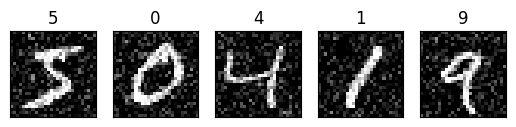

In [7]:
noise_std = 0.2
X_train_noisy = add_noise(X_train[:5], 0, noise_std)
plot_example(X_train_noisy, y_train)

# Utils

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def evaluate_MSE(model, eval_dataset):
  with torch.no_grad():
    eval_output = model(eval_dataset)
    loss = F.mse_loss(eval_output, eval_dataset)
    
  return loss.item()

In [10]:
def fit(epochs, model, X_train, X_test=None):
  # prepare data loaders
  train_loader = torch.utils.data.DataLoader(X_train, batch_size=20, shuffle=True)
  
  # define loss and optimizer
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  print(model.parameters())

  train_loss_history = []
  test_loss_history = []
  
  for epoch in range(1, epochs+1):
    model.train()

    for images in train_loader:
      # reset gradient
      optimizer.zero_grad()

      # add noise
      noisy_images = add_noise(images, 0, noise_std)

      #forward pass
      output = model(noisy_images)
      loss = criterion(output, images)

      # optimizer step and backward pass
      loss.backward()
      optimizer.step()

    train_loss = evaluate_MSE(model, X_train)
    if X_test is not None:
      test_loss = evaluate_MSE(model, X_test)
      test_loss_history.append(test_loss)
      print(f'Epoch: {epoch} \tTraining Loss: {train_loss} \tTest Loss: {test_loss}')
    else:
      print(f'Epoch: {epoch} \tTraining Loss: {train_loss}')
    
    train_loss_history.append(train_loss)
    
  return [train_loss_history, test_loss_history]

In [11]:
# show a plot with 3 rows
# on the first row we will find an example of the input images with noise
# on the second row we will see images after the denoising process
# on the third row we will find the original images
def check_results(model, original, label):
  input = add_noise(original, 0, noise_std)
  with torch.no_grad():
    denoised = model(input)

  rows = 3
  columns = 5

  fig, axes = plt.subplots(rows, columns,sharey = True,figsize=(30, 10))
  for i in range(rows):
      for j in range(columns):
          if i==0:
            axes[i, j].imshow(input[j].reshape(28, 28), cmap='gray')
            axes[i, j].set_title(label[j].item(), fontsize=20) 
          if i==1:
            axes[i, j].imshow(denoised[j].reshape(28, 28), cmap='gray')
          if i==2:
            axes[i, j].imshow(original[j].reshape(28, 28), cmap='gray')

          axes[i, j].tick_params(left = False, right = False , labelleft = False,
                  labelbottom = False, bottom = False)
          
  axes[0, 0].set_ylabel("INPUT", fontsize=20)        
  axes[1, 0].set_ylabel("DENOISED", fontsize=20)
  axes[2, 0].set_ylabel("ORIGINAL", fontsize=20)
  
  plt.show()

  return denoised

In [12]:
# counting the number of free params of the model
def count_parameters(model):
    free_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"The model has {free_params} free params")

In [13]:
# plot history
def plot_history(history):
  plt.plot(history[0])
  plt.plot(history[1])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [14]:
# plot projection of the latent space into two dimension
from sklearn.manifold import TSNE
import seaborn as sns

def plot_projection(model, X, y):
  with torch.no_grad():
    latent_space = model.encode(X)

  embeddings = TSNE(n_components=2).fit_transform(torch.flatten(latent_space, 1))
  plt.figure(figsize=(10, 8))
  sns.scatterplot(
      x=embeddings[:, 0], y=embeddings[:, 1],
      hue=y,
      palette=sns.color_palette("hls", 10),
      legend="full",
  )
  plt.tight_layout()
  plt.axis('off')

In [15]:
from skimage.metrics import structural_similarity as ssim

# compute reconstruction accuracy using SSIM score
def ssim_score(original, reconstruction):
  ''' 
    Compute the mean SSIM score between two set of images

    Args:
        original (number_of_images*number_of_pixel_per_image): array of original images.
        reconstruction (number_of_images*number_of_pixel_per_image): array of reconstructed images.
  '''
  
  ssim_score=0
  for i in range(len(original)):
    ssim_score +=ssim(original[i].detach().numpy(), reconstruction[i].detach().numpy())

  # mean overall the samples
  ssim_score /= len(original)
  print(f"SSIM score: {ssim_score}")


# Single Layer Autoencoder

In [16]:
class Autoencoder(nn.Module):
  """
    This class implements the single layer AutoEncoder made of a
    first dense layer (input_dim, encoding_dim) that implements the econder
    and a second dense layer (encoding_dim, input_dim) for the decoder

    Args:
        input_dim (int): integer that rapresents the dimesion of the input data.
        enc_dim (int): integer that rapresents the dimesion of the latent space.
        last (bool): if true the activation function of the decoder is a Sigmoid function
                     otherwhise it is ReLU.
  """

  def __init__(self, input_dim, enc_dim, last=True):
    super(Autoencoder, self).__init__()
    self.input_dim = input_dim
    self.enc_dim = enc_dim
    # encoder made of one linear layer that maps a vector of size input dim into a vector of size enc_dim
    self.encoder = nn.Linear(input_dim, enc_dim)
    # the decoder will reconstruct the image in the original space
    self.decoder = nn.Linear(enc_dim, input_dim)

    self.enc_activation = nn.ReLU()
    if last:
      self.dec_act = nn.Sigmoid()
    else:
      self.dec_act = nn.ReLU()
   
  def encode(self, x):
    x = self.encoder(x)
    x = self.enc_activation(x)
    return x
  
  def decode(self, x):
    x = self.decoder(x)
    x = self.dec_act(x)
    return x

  def forward(self, x):
    x = self.encode(x)
    x = self.decode(x)
    return x

To make the comparison between the models, they need to have a similar number of free parameters.
I then print the number of free parameters of the model so that I can later create a deep autoencoder with the same number of free parameters

In [17]:
sae = Autoencoder(X_train.shape[1], 300)
count_parameters(sae)

The model has 471484 free params


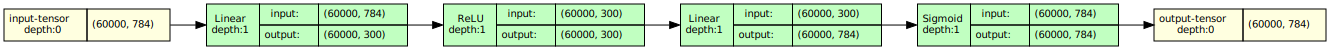

In [18]:
model_graph = draw_graph(sae, input_size=X_train.shape, expand_nested=True, graph_dir='LR')
model_graph.resize_graph(scale=10)
model_graph.visual_graph

In [19]:
epochs = 10
history = fit(epochs, sae, X_train, X_test)

<generator object Module.parameters at 0x7f92ccf9ca50>
Epoch: 1 	Training Loss: 0.03725346177816391 	Test Loss: 0.036692868918180466
Epoch: 2 	Training Loss: 0.018293028697371483 	Test Loss: 0.018157033249735832
Epoch: 3 	Training Loss: 0.0076687936671078205 	Test Loss: 0.007718566805124283
Epoch: 4 	Training Loss: 0.004664610605686903 	Test Loss: 0.004771951586008072
Epoch: 5 	Training Loss: 0.003941005561500788 	Test Loss: 0.0040707895532250404
Epoch: 6 	Training Loss: 0.0037504802457988262 	Test Loss: 0.0038896463811397552
Epoch: 7 	Training Loss: 0.0033553591929376125 	Test Loss: 0.0035055247135460377
Epoch: 8 	Training Loss: 0.0032605500891804695 	Test Loss: 0.0034171182196587324
Epoch: 9 	Training Loss: 0.0032364213839173317 	Test Loss: 0.0033959352876991034
Epoch: 10 	Training Loss: 0.003168111201375723 	Test Loss: 0.0033288656268268824


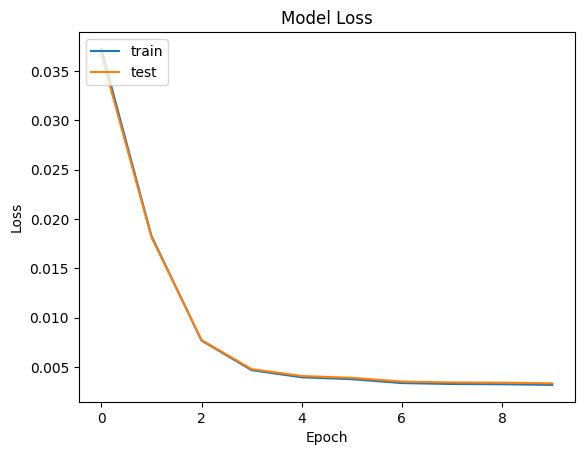

In [20]:
plot_history(history)

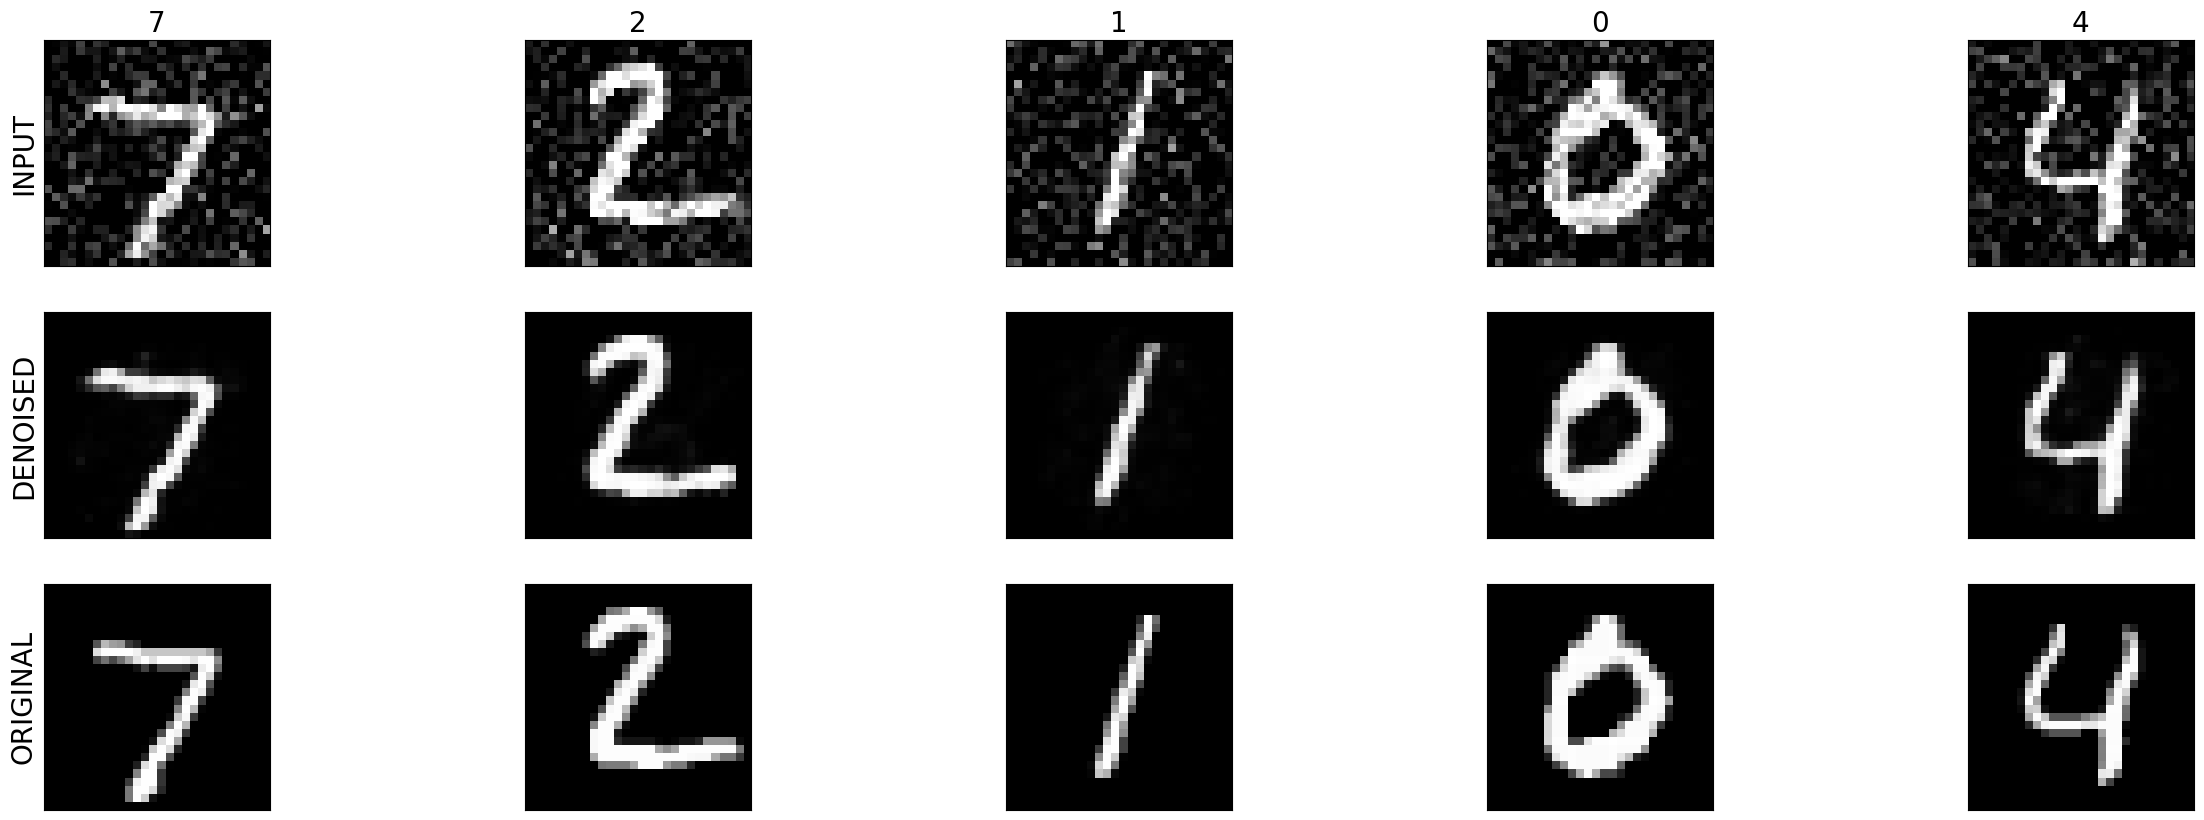

In [21]:
denoised = check_results(model=sae, original=X_test, label=y_test)

In [22]:
ssim_score(X_test, denoised)

SSIM score: 0.9192825480855278


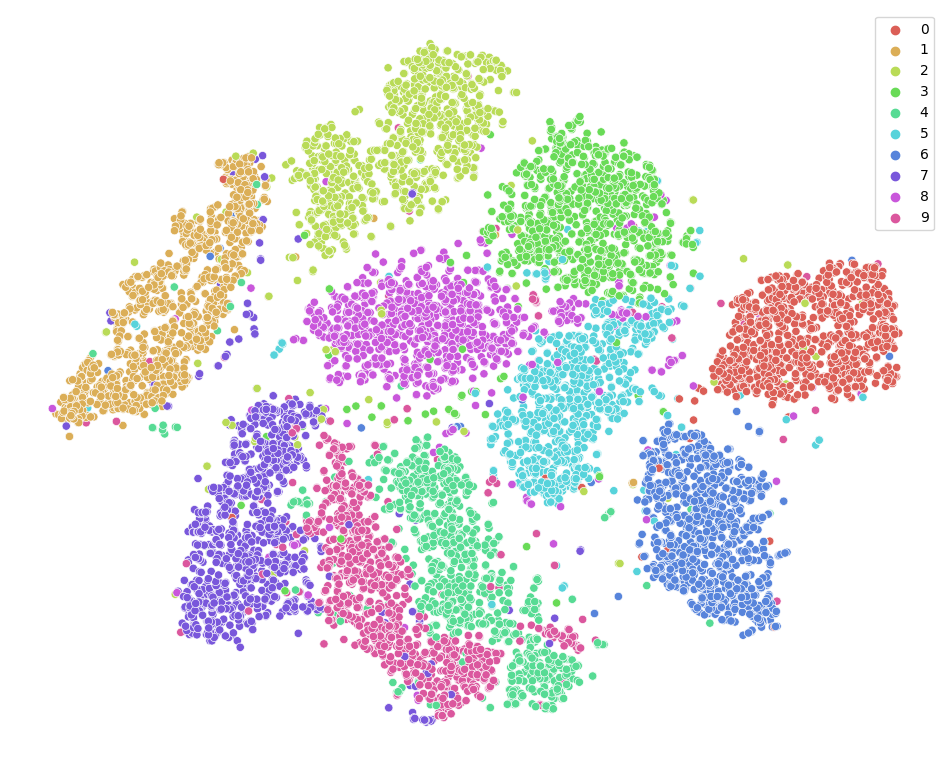

In [23]:
plot_projection(sae, X_test, y_test)

# Deep AutoEncoder with only layerwise pretraining

In [24]:
class DeepAutoEncoder(nn.Module):
  """
    This class implements the DeepAutoEncoder as a list of Single Layer Autoencoder

    Args:
        input_dim (int): integer that rapresents the dimesion of the input data.
        hidden_layers (list(int)): the length of the list defines the numbers of hidden layer
                                   each element of the list defines the latent space dimension of each layer.
  """

  def __init__(self, input_dim, hidden_layers):
    super().__init__()

    # first layer, the decoder will reconstruct the image
    self.autoencoders = [Autoencoder(input_dim, hidden_layers[0],last=False)]
    print(f"Adding autoencoder with dim {input_dim} {hidden_layers[0]}")
    input_dim = hidden_layers[0]
    hidden_layers.pop(0)

    for elem in hidden_layers:
      print(f"Adding autoencoder with dim {input_dim} {elem}")
      self.autoencoders.append(Autoencoder(input_dim, elem, last=False))
      input_dim = elem
      
    self.model = nn.ModuleList(self.autoencoders)
  
  def encode(self, x):
    enc = x
    for ae in self.model:
      enc = ae.encode(enc)
    return enc

  def decode(self, x):
    dec = x
    # reverse list of models and decode
    for ae in self.model[::-1]:
      dec = ae.decode(dec)
    return dec

  def forward(self, x):
    x = self.encode(x)
    x = self.decode(x)
    return x



In [25]:
# number of parameters of single layer autoencoder 471484 
hidden_layers = [250, 125, 60]
deep_ae = DeepAutoEncoder(X_train.shape[1], hidden_layers)
count_parameters(deep_ae)

Adding autoencoder with dim 784 250
Adding autoencoder with dim 250 125
Adding autoencoder with dim 125 60
The model has 471094 free params


In [26]:
model_graph = draw_graph(deep_ae, input_size=X_train.shape, expand_nested=True, graph_dir='LR')
model_graph.resize_graph(scale=10)
model_graph.visual_graph

In [27]:
data_in = X_train
data_in_test = X_test
for ae in deep_ae.model:
  fit(epochs, ae, data_in, data_in_test)

  # create latent rappresentation of data
  # the new encoded data_in will be passed to the data loader in the fit method
  with torch.no_grad():
    data_in = ae.encode(data_in)
    data_in_test = ae.encode(data_in_test)
    


<generator object Module.parameters at 0x7f92ca6d8660>
Epoch: 1 	Training Loss: 0.017663205042481422 	Test Loss: 0.017720013856887817
Epoch: 2 	Training Loss: 0.018602419644594193 	Test Loss: 0.01868734136223793
Epoch: 3 	Training Loss: 0.019332651048898697 	Test Loss: 0.019429482519626617
Epoch: 4 	Training Loss: 0.019227130338549614 	Test Loss: 0.01932819001376629
Epoch: 5 	Training Loss: 0.01914118230342865 	Test Loss: 0.019248727709054947
Epoch: 6 	Training Loss: 0.018868789076805115 	Test Loss: 0.01897382363677025
Epoch: 7 	Training Loss: 0.01872350461781025 	Test Loss: 0.01883118413388729
Epoch: 8 	Training Loss: 0.018814759328961372 	Test Loss: 0.018915429711341858
Epoch: 9 	Training Loss: 0.018562298268079758 	Test Loss: 0.018687304109334946
Epoch: 10 	Training Loss: 0.01831468753516674 	Test Loss: 0.018420137465000153
<generator object Module.parameters at 0x7f92ca6d8740>
Epoch: 1 	Training Loss: 0.06331905722618103 	Test Loss: 0.0652945339679718
Epoch: 2 	Training Loss: 0.063

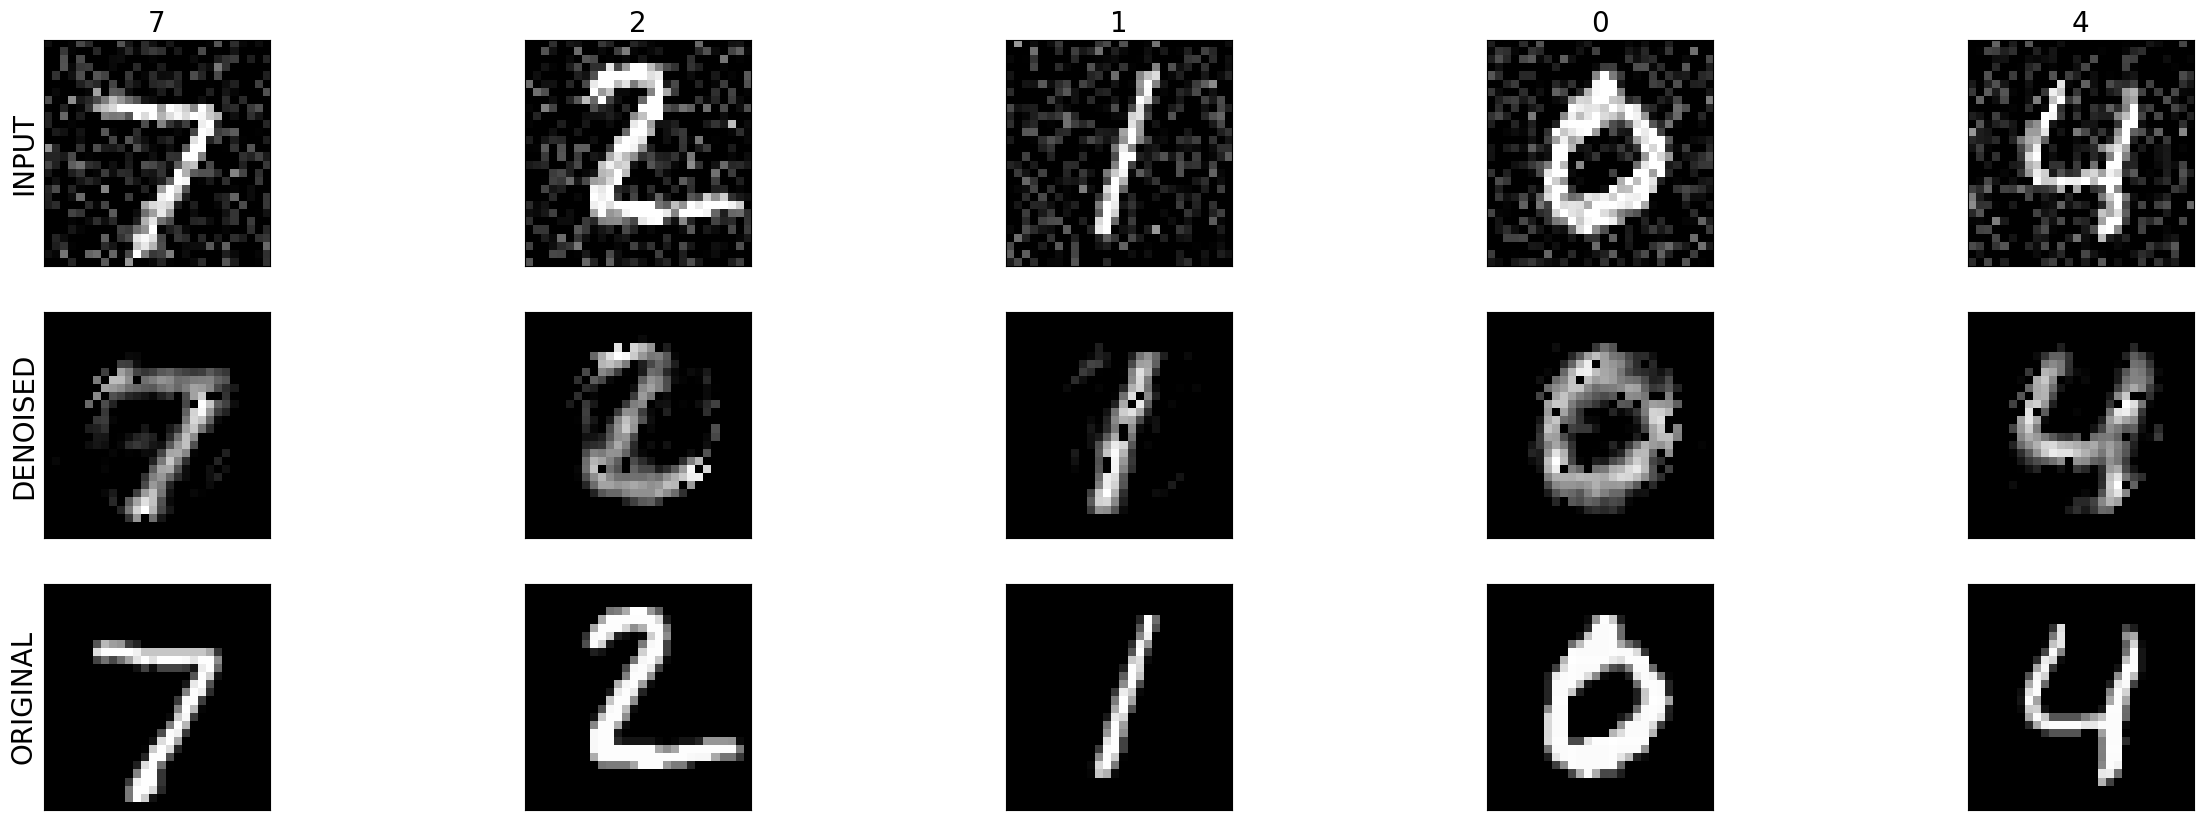

In [28]:
denoised = check_results(model=deep_ae, original=X_test, label=y_test)

In [29]:
ssim_score(X_test, denoised)

SSIM score: 0.5879221084731305


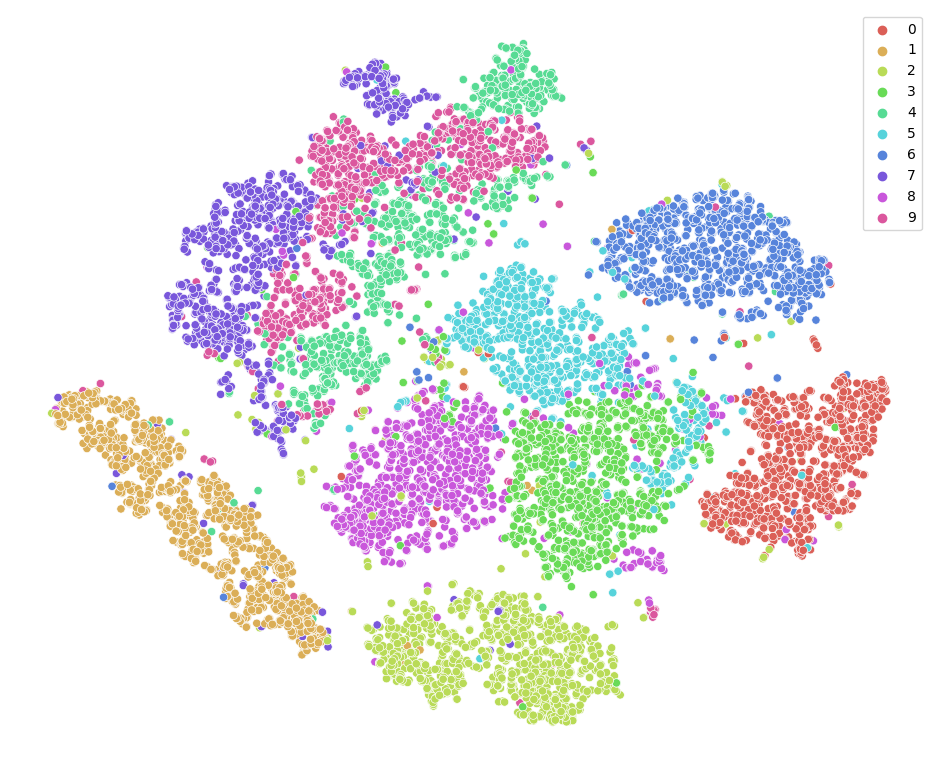

In [30]:
plot_projection(deep_ae, X_test, y_test)

# Deep AutoEncoder with Fine Tuning

In [31]:
# reusing the deep autencoder pretrained before
history = fit(epochs, deep_ae, X_train, X_test)

<generator object Module.parameters at 0x7f92ca6daff0>
Epoch: 1 	Training Loss: 0.022748036310076714 	Test Loss: 0.022673623636364937
Epoch: 2 	Training Loss: 0.018951507285237312 	Test Loss: 0.018907176330685616
Epoch: 3 	Training Loss: 0.017987482249736786 	Test Loss: 0.01794380694627762
Epoch: 4 	Training Loss: 0.016675889492034912 	Test Loss: 0.016666924580931664
Epoch: 5 	Training Loss: 0.016682026907801628 	Test Loss: 0.016665825620293617
Epoch: 6 	Training Loss: 0.01605592854321003 	Test Loss: 0.016074104234576225
Epoch: 7 	Training Loss: 0.016153991222381592 	Test Loss: 0.0161718912422657
Epoch: 8 	Training Loss: 0.015659552067518234 	Test Loss: 0.015690796077251434
Epoch: 9 	Training Loss: 0.0156813096255064 	Test Loss: 0.015715619549155235
Epoch: 10 	Training Loss: 0.016014540567994118 	Test Loss: 0.016063757240772247


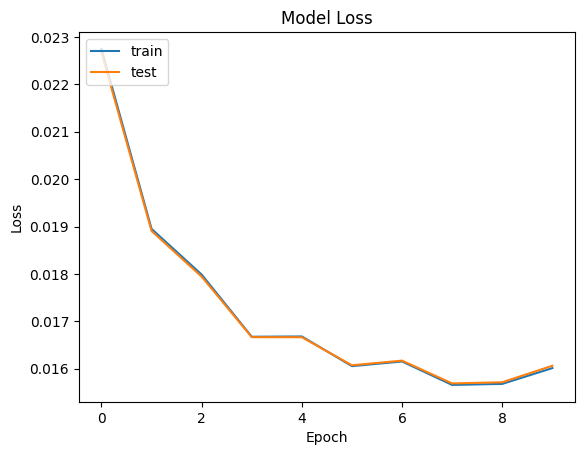

In [32]:
plot_history(history)

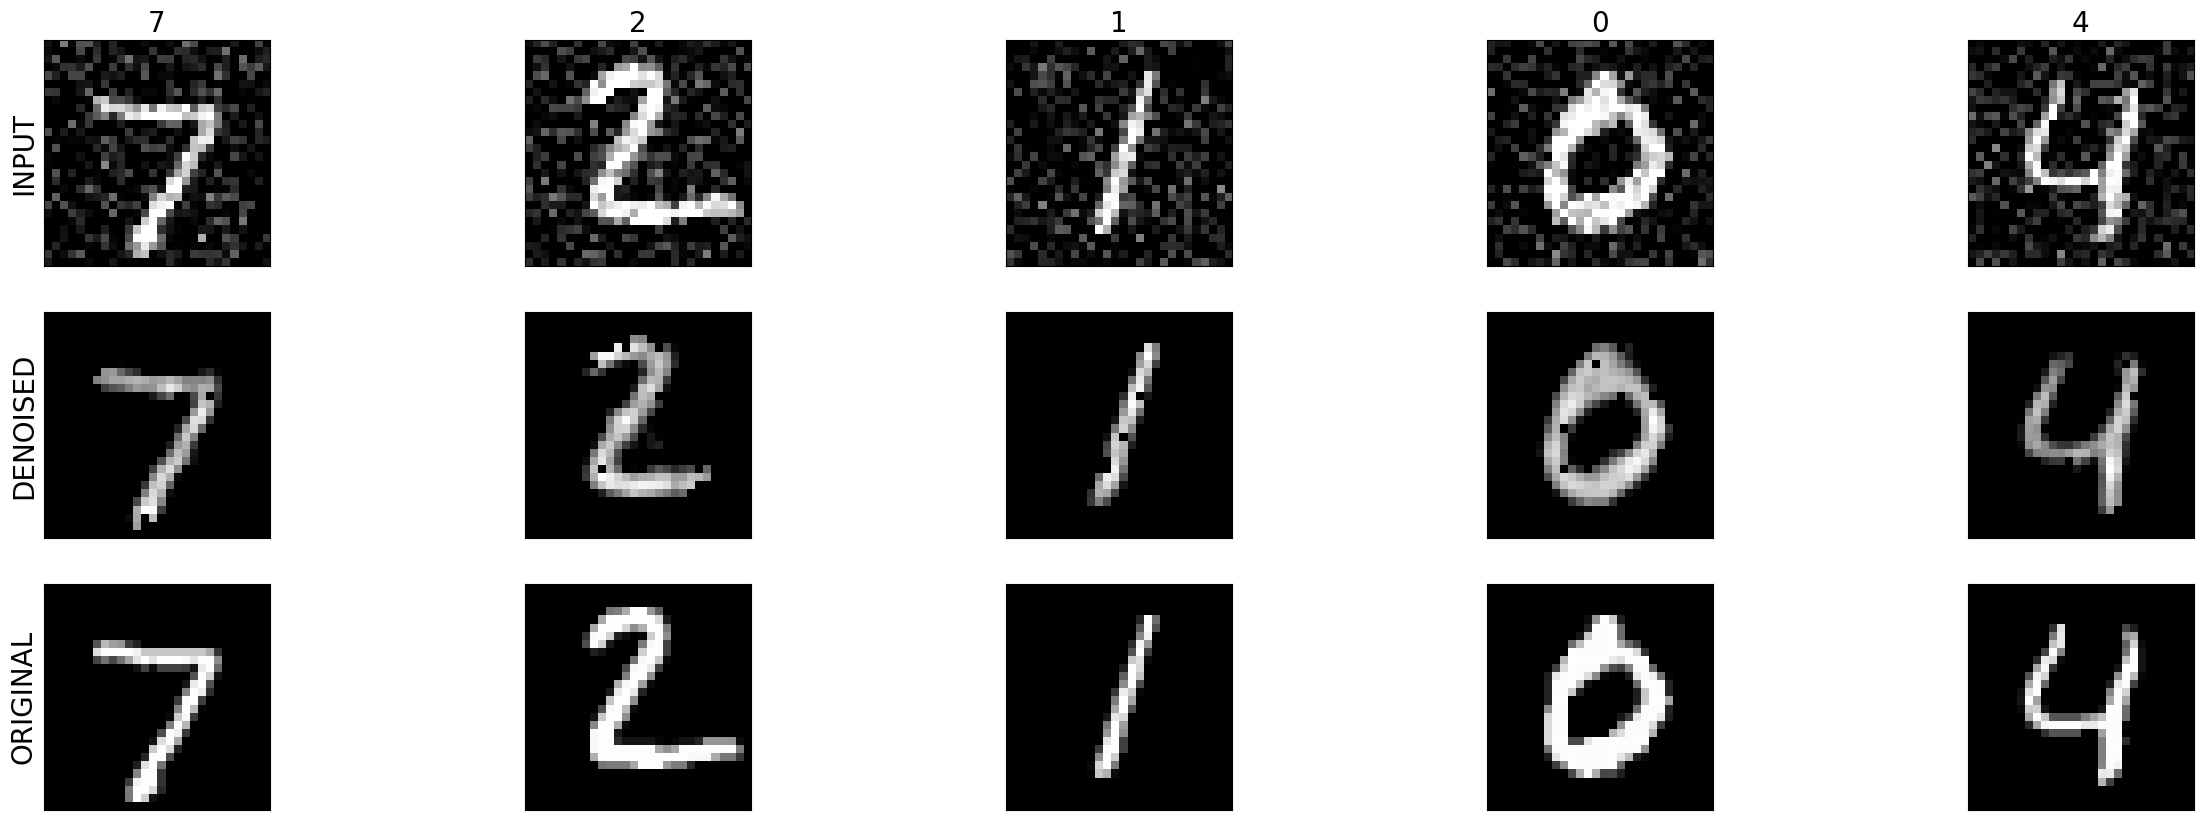

In [33]:
denoised = check_results(model=deep_ae, original=X_test, label=y_test)

In [34]:
ssim_score(X_test, denoised)

SSIM score: 0.8975744115853886


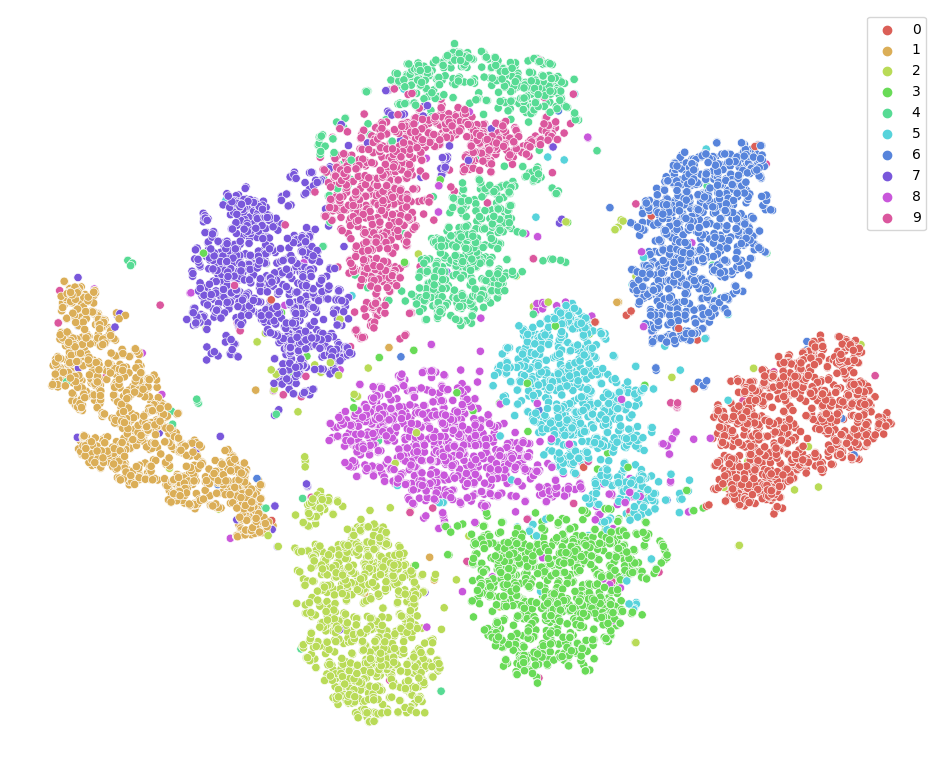

In [35]:
plot_projection(deep_ae, X_test, y_test)

# Latent Space Interpolation

Given the encoding z1 of image x1 (obtained in the hidden layer of the autoencoder) and z2 of image x2, a latent space interpolation is an encoding that is obtained with the linear interpolation z* = a*z1 + (1 - a)*z2, with a in [0, 1]. Perform a latent space interpolation (with some choices of a) using:
- z1 and z2 from the same class
- z1 and z2 from different classes

Once you have the interpolated encoding z* visualize its image reconstructions (obtained through the decoder) and discuss the results.

In [36]:
def plot_interpolations(X, alphas):
    """Plot 5 images in a row."""
    f = plt.figure(figsize=(20,3))

    for i, img in enumerate(X):
        img = img.reshape((28, 28))
        plt.subplot(161 + i)
        plt.imshow(img, cmap='gray', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        plt.title(f"alpha: {alphas[i]}")

In [37]:
def compute_interpolation(model, img1, img2):
  with torch.no_grad():
    encoding1 = model.encode(img1)
    encoding2 = model.encode(img2)

    # trying different values of alphas
    alphas = np.arange(0.0, 1.1, 0.2)
    interpolated_images = []
    for i, alpha in enumerate(alphas):
      alpha = round(alpha,1)
      alphas[i]=alpha
      interpolation = alpha *encoding1 + (1 - alpha)*encoding2
    
      #compute decoding starting from the interpolation
      result = model.decode(interpolation)
      interpolated_images.append(result)

    plot_interpolations(interpolated_images, alphas)

## Interpolation using images of the same class

In [38]:
# choose two images of the class 5

# Find indices of all examples with label 5
idx_5 = (y_test == 5)

# Filter X_test to get examples with label 5
X_test_5 = X_test[idx_5]
X_test_5.shape

torch.Size([892, 784])

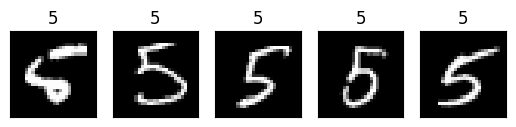

In [39]:
plot_example(X_test_5, y_test[idx_5])

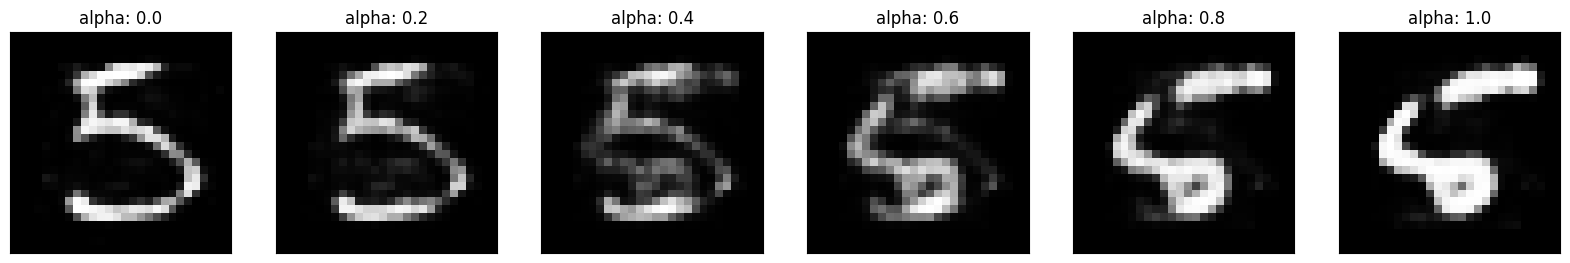

In [40]:
# select the first two images
img1 = X_test_5[0]
img2 = X_test_5[1]

# to show the result of a latent space interpolation 
# I choose as model the single layer autoencoder trained before

# compute latent space representation for two different images
compute_interpolation(sae, img1, img2)

## Interpolation using images of different classes

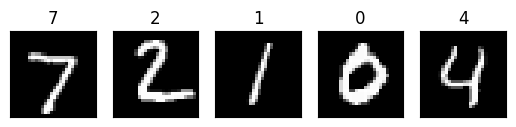

In [42]:
plot_example(X_test, y_test)

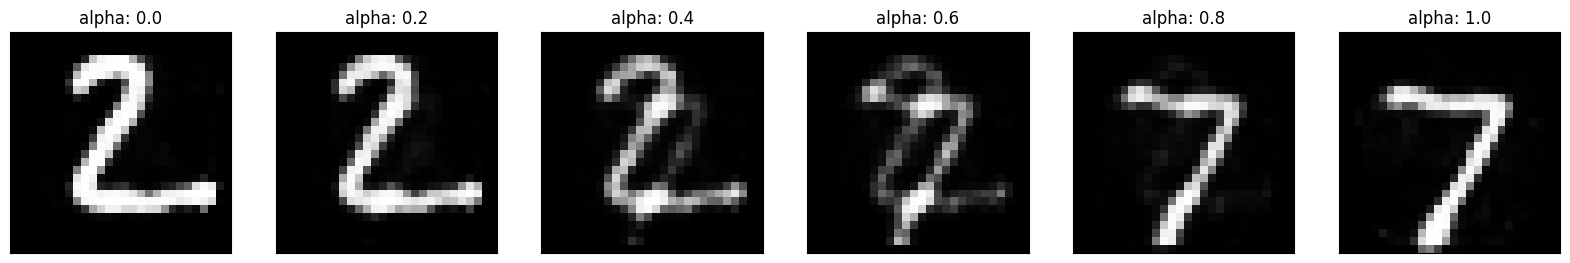

In [43]:
# select the first two images 
img1 = X_test[0]
img2 = X_test[1]

# to show the result of a latent space interpolation 
# I choose as models the single layer autoencoder trained before

# compute latent space representation for two different images
compute_interpolation(sae, img1, img2)

# Conclusions

In this notebook, different implementations of an autoencoder model were presented by testing it on the MNIST dataset.
The implemented autoencoders are a Single Layer AutoEncoder (sae), a Deep AutoEncoder using only layerwise pretraining (dae) and finally Fine Tuning was performed on the deep model.
Since the dataset consists of images the autoencoder could be created using convolutional networks, but for simplicity and since the dataset consists of simple images the sae is implemented with a dense layer for the encoding part and a dense layer for the decoding part.
The dae model without fine tuning is constructed by stacking sae models one after the other.
Here each sae is trained on its own, taking the encoding obtained from the previous layer as input.
Finally, Fine Tuning is performed on the dae model.
The metric chosen to train the models is the MSE, while the metric chosen to measure the accuracy of the reconstructions is the SSIM score evaluated on the test set.
Model comparison is also performed by creating models that have a similar number of free parameters. 

As can be seen from the SSIM score results for the 3 models, the sae performs best of all, obtaining a score of 0.91 and reconstructing the test set images very well. The dae using only layerwise pretraining is the one that performs worst on the reconstructions of the images. Fine tuning on this model helps to improve image reconstruction but fails to achieve the same accuracy as sae. This is probably because the dataset is simple and the task of the deep autoencoders is not to reconstruct the images but to extrapolate information at various levels of abstraction.

The 2D projection of the latent space is also useful to understand if the model can learn how to represent the data, this projection is more confusing in the dae with only layerwise pretraining while the classes are very well separated using Fine Tuning

Note that model selection was not performed for the choice of the values of the hyperparameters, a good selection of hyperparameters could lead to better results, but in the experiments it was noted that the choice of neurons per hidden layer in the dae affects the loss a lot. If, for example, 64 neurons are chosen for the first hidden layer, 32 for the second and 16 for the third, it can be seen that already in the second hidden layer the autoencoder can no longer reconstruct its input.

For latent space interpolation, first two images belonging to the number class 5 were chosen to interpolate latent spaces of the same class, then two images one representing a 7 and one representing a 2 to interpolate latent spaces of different classes.
The interpolation was performed with increasing alpha values from 0.0 to 1.0.
Obviously, the more weight given to the first or second latent space, the more similar the resulting image will be to the first or second image. This is shown very well in the plots above.
For alpha around 0.5 the resulting image is a mixture of the two, which may not make much sense graphically since we are moving linearly on the manifold and we could move in directions that don't make sense.